# HPC Society Project

In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn
import os
import xlrd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, Matern
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [7]:
data_dir = r"./Data/TOP500_2005_2021"

## Part 1 : Analysis of HPC nowadays

Manufacturers produce the world’s 50 largest supercomputers: 
 ['ACTION', 'AMAZON WEB SERVICES', 'ASUS CLOUD', 'ATIPA', 'ATOS', 'CLUSTERVISION', 'CRAY INC.', 'DELL EMC', 'EXASCALER INC.', 'FUJITSU', 'HAMMER', 'HITACHI', 'HPE', 'HUAWEI', 'IBM', 'INSPUR', 'INTEL', 'LENOVO', 'LIQID', 'MEGWARE', 'MELLANOX', 'MICROSOFT AZURE', 'NEC', 'NRCPC', 'NUDT', 'NVIDIA', 'PENGUIN COMPUTING', 'PEZY COMPUTING', 'PREFERRED NETWORKS', 'QUANTA COMPUTER', 'SELF-MADE', 'SUGON', 'SUPERMICRO', 'T-PLATFORMS', 'TAIWAN FIXED NETWORK', 'YANDEX']


Processors used (by generation)- 10 largest:
 ['Fujitsu A64FX' 'IBM POWER9' 'Sunway' 'AMD Milan' 'AMD Rome'
 'Intel Xeon E5 (IvyBridge)' 'Xeon Gold 62xx (Cascade Lake)'
 'Xeon Platinum 82xx (Cascade Lake)' 'Xeon Gold' 'Intel Xeon E5 (Haswell)'
 'Intel Xeon Phi' 'Xeon Platinum' 'Xeon® Platinum 83xx (Ice Lake)'
 'Vector Engine' 'Intel Xeon E5 (Broadwell)'
 'Xeon Platinum 92xx (Cascade Lake)' 'Hygon Dhyana' 'Xeon Silver'
 'Xeon 5600-series (Westmere-EP)' 'Intel Xeon E5 (San

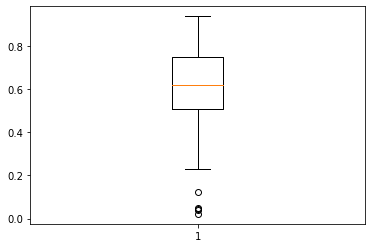

In [17]:
df = pd.read_excel(f"{data_dir}//TOP500_202111.xlsx", header=0)
dforig = df.copy()
def manu():
    manufacturers = set()
    for manufacturer in df["Manufacturer"].unique():
        if "," in manufacturer:
            parteners = manufacturer.split(",")
            [manufacturers.add(partener.strip().upper()) for partener in parteners]
        elif "/" in manufacturer:
            parteners = manufacturer.split("/")
            [manufacturers.add(partener.strip().upper()) for partener in parteners]
        else:
            manufacturers.add(manufacturer.upper())
    return sorted(list(manufacturers))

manuf = manu()

print("Manufacturers produce the world’s 50 largest supercomputers: \n", manuf)

# df.loc[:, "Processor"].unique()  # Highly specific
print("\n\nProcessors used (by generation)- 10 largest:\n", df.loc[:, "Processor Generation"].unique())  # specific

df = df.iloc[:10, :]

manuf = manu()
print("\nManufacturers produce the world’s 10 largest supercomputers: \n", manuf)

# df.loc[:, "Processor"].unique()  # Highly specific
print("\n\nProcessors used (by generation) - 10 largest:\n", df.loc[:, "Processor Generation"].unique())  # specific

df = dforig
frac_mean = (df["Rmax [TFlop/s]"] / df["Rpeak [TFlop/s]"]).mean()
frac_var = (df["Rmax [TFlop/s]"] / df["Rpeak [TFlop/s]"]).std()
plt.boxplot(df["Rmax [TFlop/s]"] / df["Rpeak [TFlop/s]"])
print("\n\nFraction of peak performance typically achieved for the LINPACK benchmark:\n", 
      "Mean:", frac_mean, "\n Variance:", frac_var)

## Part 2 : Prediction of Rpeak, Rmax, Total number of cores and Core speed for the next 5 years

First of all, we have to import all the data and treat it to be able to make predictions from it. In order to avoid repeated data from the same year, the second data of the same year is added by the value of 0.5.

In [61]:
data_dir = r"./Data/TOP500_2005_2021"
years = []
columns =  ["Rmax", "Rpeak", "Ncores", "Speed"]

for i, file in enumerate(list(os.walk(data_dir))[0][2]):
#     s = set()
    head = 1 if i < 6 else 0
    try:
        wb = xlrd.open_workbook(f"{data_dir}//{file}", logfile=open(os.devnull, 'w'))  # xlrd
        df = pd.read_excel(wb, header=head)
    except:
        df = pd.read_excel(f"{data_dir}//{file}", header=head)  # openpyxl
    
    df.columns = df.columns.str.replace("Processors", "Ncores", regex=False)
    df.columns = df.columns.str.replace("Total Cores", "Ncores", regex=False)
    df.columns = df.columns.str.replace("Rmax [TFlop/s]", "Rmax", regex=False)
    df.columns = df.columns.str.replace("RMax", "Rmax", regex=False)
    df.columns = df.columns.str.replace("Rpeak [TFlop/s]", "Rpeak", regex=False)
    df.columns = df.columns.str.replace("RPeak", "Rpeak", regex=False)
    df.columns = df.columns.str.replace("Proc. Frequency", "Speed", regex=False)
    df.columns = df.columns.str.replace("Processor Speed (MHz)", "Speed", regex=False)
    df.columns = df.columns.str.replace("Cores Speed (MHz)", "Speed", regex=False)
    df.columns = df.columns.str.replace("Ncores Speed (MHz)", "Speed", regex=False)
    if i >= 7 and i <= 13:
        df.columns = df.columns.str.replace("Cores", "Ncores", regex=False)
    
    if i < 24: # Convert to Tflop/s
        df.loc[:, "Rmax"] = df.loc[:, "Rmax"] / 1e3
        df.loc[:, "Rpeak"] = df.loc[:, "Rpeak"] / 1e3
        
    df = df[columns]
    df.columns = df.columns.str.replace("Rpeak", "Rpeak [TFlop/s]", regex=False)
    df.columns = df.columns.str.replace("Rpeak", "Rpeak [TFlop/s]", regex=False)


    labels = df.iloc[:, :4].mean().values
    year = 2005 + i //2
    if i % 2 == 1:
        year += 0.5
    years.append(year)

    if i == 0:
        labels_data = labels
    else:
        labels_data = np.vstack([labels_data, labels])


Now that all the data is in the right format, that is, we have for each year a ground truth data for the label we want to forecast, we can use analyse the relationship between those labels and from them with the year.

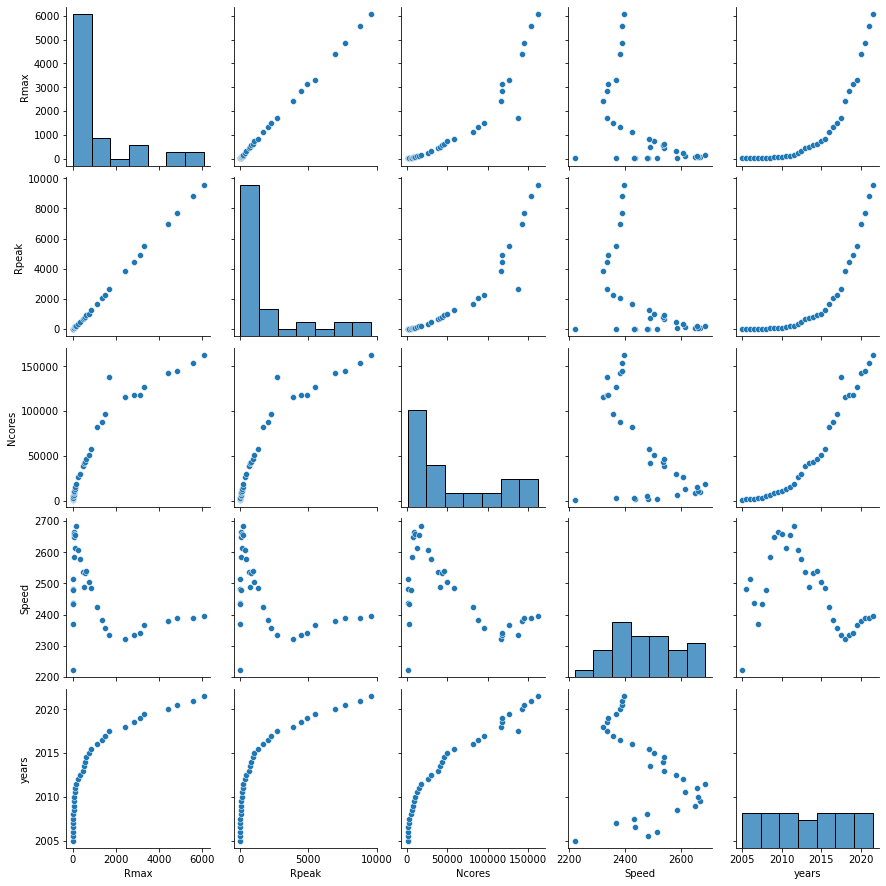

In [62]:
df_plot = pd.DataFrame(np.c_[labels_data, np.array(years)], columns = columns + ["years"])
sns.pairplot(df_plot)

We can infer from the data that polynomial algorithms can be of good use for the forecast, so we are going to try them and a few others in order to discover the best one. To choose the best model, instead of randomly separating the data in test and training data sets, we are going to use only the last 5 points to test. In this way, we can analyse not the interpolation performance of the model, but its extrapolation performance; in other words, its capability to forecast. Ideally, a special forcasting gridsearch could be made.

Moreover, from the graphs above, we can see that the 3 first labels have a really similar behavior, and could maybe be trained togheter, while the fourth one (Speed) presents a different behavior. Nevertheless, we are going to train all separately for simplicity.

In [88]:
# No need to scale in this first moment because we are analysing the relationship between one feature and one output
# MAP as coast function
X = np.array(years)

for i, y in enumerate(labels_data.T):
    X_train = X[:29].reshape((-1, 1))
    X_test = X[29:].reshape((-1, 1))
    y_train = y[:29]
    y_test = y[29:]
    
    svr = SVR(kernel="linear", C=9)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    print(f"SVR mean squared error {columns[i]}:", mean_absolute_percentage_error(y_test, y_pred))
    
    kernel = C() + Matern(length_scale=0.5, nu=3/2)
    GPR = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=7)
    GPR.fit(X_train, y_train)
    y_pred = GPR.predict(X_test)
    print(f"GPR mean squared error {columns[i]}:", mean_absolute_percentage_error(y_test, y_pred))
    
    Linear = LinearRegression()
    Linear.fit(X_train, y_train)
    y_pred = Linear.predict(X_test)
    print(f"Linear mean squared error {columns[i]}:", mean_absolute_percentage_error(y_test, y_pred))
    
    for degree in [2, 3, 4, 5, 6]:
        poly = PolynomialFeatures(degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        Linear.fit(X_train_poly, y_train)
        y_pred = Linear.predict(X_test_poly)
        print(f"Poly {degree} mean squared error {columns[i]}:", mean_absolute_percentage_error(y_test, y_pred))
    print("\n")
    
    

SVR mean squared error Rmax: 0.7273931722595405
GPR mean squared error Rmax: 0.5843833835090053
Linear mean squared error Rmax: 0.5391102469648935
Poly 2 mean squared error Rmax: 0.2324000684664413
Poly 3 mean squared error Rmax: 0.06486386810644203
Poly 4 mean squared error Rmax: 0.06443361576528663
Poly 5 mean squared error Rmax: 0.0640013787023539
Poly 6 mean squared error Rmax: 0.06356941684473234


SVR mean squared error Rpeak: 0.7593241773398768
GPR mean squared error Rpeak: 0.5890342725154506
Linear mean squared error Rpeak: 0.5545756996923188
Poly 2 mean squared error Rpeak: 0.24532390790192143
Poly 3 mean squared error Rpeak: 0.04376115931418822
Poly 4 mean squared error Rpeak: 0.043283414611472754
Poly 5 mean squared error Rpeak: 0.042813948049137185
Poly 6 mean squared error Rpeak: 0.04234476189025264


SVR mean squared error Ncores: 0.7596747953470346
GPR mean squared error Ncores: 0.5646047679924238
Linear mean squared error Ncores: 0.17663965359790432
Poly 2 mean squared 

For the first 3 labels, the polynomial models do really well, specially from the 3rd degree forward. To avoid an unnecessary degree of complexity, which could result in poor generalisation for the main forecast, we can choose a polynomial degree of 3. To model the Speed however, other models perform better and seen a better fit to the data complexity. A linear model, despite of the low mean error, should be too simple for this data, which clearly does not present a linear behavior. In this way, let's choose an SVR model.

We can train these models in the whole dataset we have and forecast for the next 5 years. Then, we can plot the graphics below.

In [89]:
X_forecast = [[2022], [2023], [2024], [2025], [2026]]
Rmax, Rpeak, Ncores, Speed = labels_data.T
poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(X.reshape((-1, 1)))
X_forecast_poly = poly.fit_transform(X_forecast)

Linear.fit(X_train_poly, Rmax)
Rmax_forecast = Linear.predict(X_forecast_poly)

Linear.fit(X_train_poly, Rpeak)
Rpeak_forecast = Linear.predict(X_forecast_poly)

Linear.fit(X_train_poly, Ncores)
Ncores_forecast = Linear.predict(X_forecast_poly)

svr = SVR(kernel="linear", C=9)
svr.fit(X.reshape((-1, 1)), Speed)
Speed_forecast = svr.predict(X_forecast)

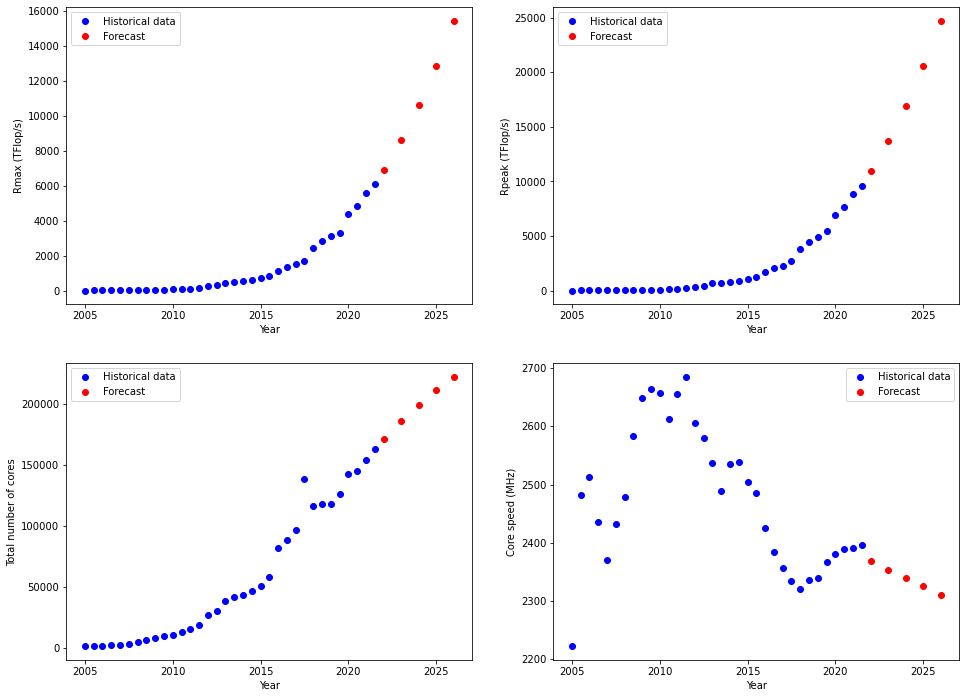

In [90]:
fig, axs = plt.subplots(2, 2, figsize=(16,12))

axs[0, 0].plot(X, Rmax, 'bo', label="Historical data")
axs[0, 0].plot(np.array(X_forecast).flatten(), Rmax_forecast, 'ro', label="Forecast")
axs[0, 0].set(xlabel='Year', ylabel='Rmax (TFlop/s)')
axs[0, 0].legend()

axs[0, 1].plot(X, Rpeak, 'bo', label="Historical data")
axs[0, 1].plot(np.array(X_forecast).flatten(), Rpeak_forecast, 'ro', label="Forecast")
axs[0, 1].set(xlabel='Year', ylabel='Rpeak (TFlop/s)')
axs[0, 1].legend()

axs[1, 0].plot(X, Ncores, 'bo', label="Historical data")
axs[1, 0].plot(np.array(X_forecast).flatten(), Ncores_forecast, 'ro', label="Forecast")
axs[1, 0].set(xlabel='Year', ylabel='Total number of cores')
axs[1, 0].legend()

axs[1, 1].plot(X, Speed, 'bo', label="Historical data")
axs[1, 1].plot(np.array(X_forecast).flatten(), Speed_forecast, 'ro', label="Forecast")
axs[1, 1].set(xlabel='Year', ylabel='Core speed (MHz)')
axs[1, 1].legend()

The behavior of the curves seem adequate. Let's analyse them with respect to the Moore law, which say that the number of transistors by core should double each 2 years, resulting in the double of the total number of cores.

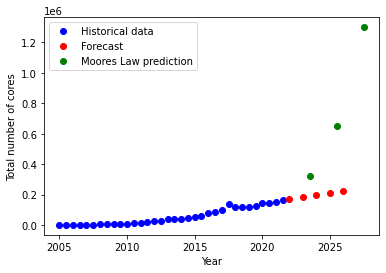

In [71]:
moore_years = [2023.5, 2025.5, 2027.5]
moore_predictions = [Ncores[-1]*2, Ncores[-1]*4, Ncores[-1]*8]
plt.plot(X, Ncores, 'bo', label="Historical data")
plt.plot(np.array(X_forecast).flatten(), Ncores_forecast, 'ro', label="Forecast")
plt.plot(moore_years, moore_predictions, 'go', label="Moores Law prediction")
plt.xlabel('Year')
plt.ylabel('Total number of cores')
plt.legend()

As we can see, our predictions are much more conservative than the Moore Law, supporting the fact that it does not work anymore.